# Comparing two datasets
One of the simplest analyses we can make with a dataset is splitting it into groups (perhaps by experimental condition), and comparing some statistic between them. This tutorial will cover such "first-pass" analyses when the data naturally breaks into groups, and relatively simple statistics can be calculated between them

# The t-test
## Data Introduction
Octopamine has been implicated in modulating feeding behaviors in both vertebrates and invertebrates. Pargyline has been shown to increase the levels of octopamine in the nervous system. The role of Pargyline in sucrose consumption was tested in blowflies. Two groups of blowfies were used in this study: one group was injected with Parglyine (n=295 flies) while the control group was injected with saline (n = 300 flies). The amount of sucrose consumed was then measured. [adapted from Samuels & Witmer, pg 220. Originally: Long & Murdock, PNAS 1983]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import (ttest_ind, ttest_1samp, ttest_rel,
                         wilcoxon, ks_2samp)
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm

%matplotlib inline

First we'll load the data and take a look at it's structure. We'll note that each column is a variable, and each row is a data point. Some of the columns have `NaN`, because that variable doesn't apply to the particular datapoint.

In [3]:
data = pd.read_csv('../../../data/fly_feeding.csv')
data.head()

,animal,measurement,feed_type,side,measurement_type
0,NaN,21.7,saline,NaN,sucrose_consumption
1,NaN,17.0,saline,NaN,sucrose_consumption
2,NaN,11.1,saline,NaN,sucrose_consumption
3,NaN,6.3,saline,NaN,sucrose_consumption
4,NaN,19.3,saline,NaN,sucrose_consumption


In [4]:
data['feed_type'].unique()

array(['saline', 'pargyline', 'saline_two', 'parglyine_w_yohimbine', nan,
       'feeding_type_1', 'feeding_type_2'], dtype=object)

First, let's look at the distributions for feeding behavior under parglyine and saline

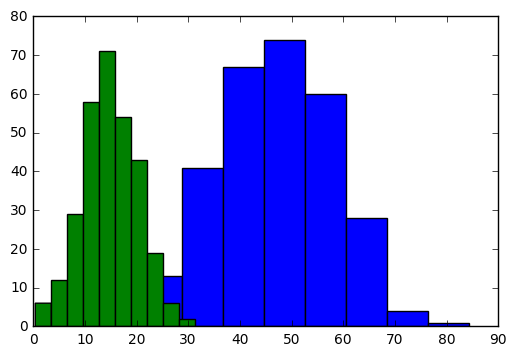

In [5]:
data_par = data.query('feed_type == "pargyline"')['measurement'].values
data_sal = data.query('feed_type == "saline"')['measurement'].values

fig, ax = plt.subplots()
ax.hist(data_par)
_ = ax.hist(data_sal)

We'll also show the data as a boxplot, which is sometimes easier to interpret.

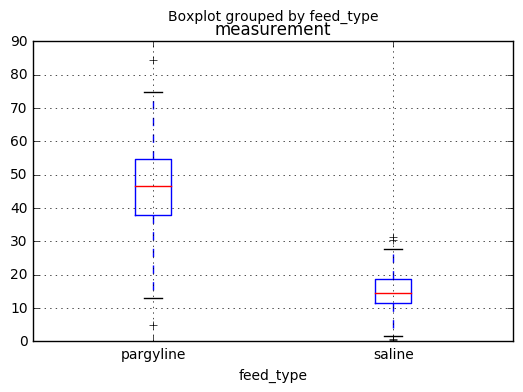

In [6]:
data.query('feed_type in ["pargyline", "saline"]').\
    boxplot('measurement', by='feed_type')

We want to test for whether there is a statistical difference between the means of these two distributions. Because the two distributions look (relatively) normally distributed, s two-sample t-test seems like it may be useful. Let's perform this below.

In [7]:
res = ttest_ind(data_par, data_sal)
print(res)

Ttest_indResult(statistic=41.861017904148426, pvalue=3.3320050655092234e-179)


Here we can see that, according to the t-test, there is a highly significant difference in the feeding behavior for these groups.

## Follow-up experiment
To further confirm octopamine positively modulates feeding behavior, an additional experiment was done with Yohimbine (an antagonist of octopamine receptors in insects). One group was injected with Parglyine and Yohimbine (n = 130) while an additional control group was injected with saline (n = 100). The amount of sucrose consumed was then measured.

First, we'll once again visualize the two conditions as histograms and boxplots. 

In [8]:
data_par_yoh = data.query('feed_type == "parglyine_w_yohimbine"')
data_par_yoh = data_par_yoh['measurement'].values

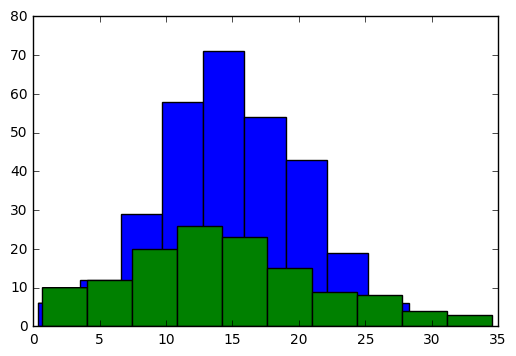

In [9]:
fig, ax = plt.subplots()
ax.hist(data_sal)
_ = ax.hist(data_par_yoh)

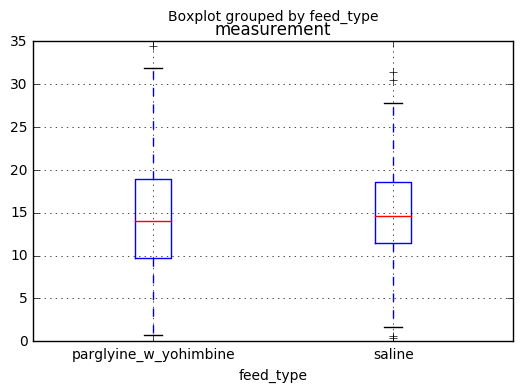

In [10]:
data_box = data.query('feed_type in ["parglyine_w_yohimbine", "saline"]')
data_box.boxplot('measurement', by='feed_type')

We'll run a t-test once again to test for any difference between these groups.

In [11]:
res = ttest_ind(data_sal, data_par_yoh)
print(res)

Ttest_indResult(statistic=0.66622501018272595, pvalue=0.50562622201652518)


Here it seems like there is *no* difference between the groups...their means are not far enough apart to conclude statistical significance. However, would you conclude that the two distributions are not different at all? That's hard to say. For example, there seems to be a strong difference in the **variance** between the two distributions. This is something you should always pay attention to.

Finding more complex relationships in your data requires different kinds of tests. Next we'll look at a slightly different version of the t-test: the "paired" t-test.

# Paired t-tests
## About the data
Certain types of nerve cells have the ability to regenerate a part of the cell that has been amputated. In an early study of this process, measurements were made on the nerves in the the spinal cord of rhesus monkeys. Nerves emanating from the left side of the cord were cut, while nerves from the right side were kept intact. During the regeneration process, the amount of creatine phosphate (CP) was measured in the left and right portions of the spinal cord. You are interested in whether CP levels are different between the cut and control sides of the spinal cord. [adapted from Samuels & Witmer, pg 387. Originally: Bodian (1947)]

First, we'll visualize the data as a histogram + boxplot.


In [12]:
bef_aft = data.query('measurement_type == "creatine_phosphate"')
bef_aft.head()

,animal,measurement,feed_type,side,measurement_type
825,1.0,11.5,NaN,Left,creatine_phosphate
826,2.0,3.6,NaN,Left,creatine_phosphate
827,3.0,12.5,NaN,Left,creatine_phosphate
828,4.0,6.3,NaN,Left,creatine_phosphate
829,5.0,15.2,NaN,Left,creatine_phosphate


In [13]:
data_left = bef_aft.query('side == "Left"')['measurement'].values
data_right = bef_aft.query('side == "Right"')['measurement'].values

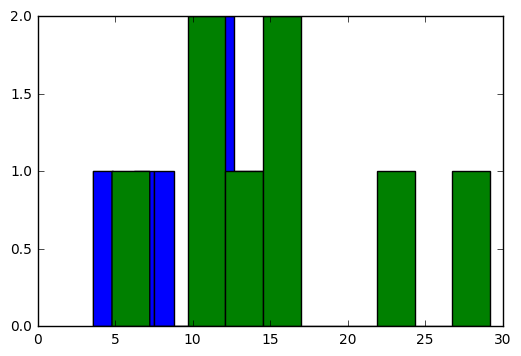

In [14]:
fig, ax = plt.subplots()
ax.hist(data_left)
_ = ax.hist(data_right)

Per our earlier analysis, we'll perform a 2-sample t-test, splitting our data into two groups, "before" and "after" treatment with creatine phosphate:

In [15]:
ttest_ind(data_left, data_right)

Ttest_indResult(statistic=-1.4847824744326941, pvalue=0.159766872901516)

There doesn't seem to be a statistical difference between the two groups. But wait one second! We have omitted an important component of our dataset. Rather than being two separate groups, there is a natural "pairing" of the data. *For each animal*, we have one recording from the left, and one from the right. This means that we can include this knowledge in our statistical test.

As a start, let's visualize the difference between left and right for *each* animal. We'll use a line plot for this.

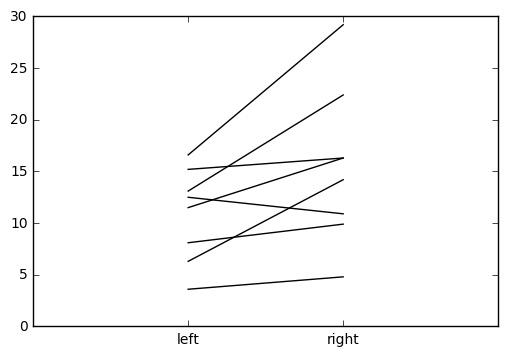

In [16]:
fig, ax = plt.subplots()
ax.plot([0, 1], [data_left, data_right], color='k')
plt.xticks([0, 1], ['left', 'right'])
_ = plt.setp(ax, xlim=[-1, 2])

Perhaps there does seem to be something going on after all. The lines in general seem to go up from left to right. To run statistics on this, we'll use a "paired" t-test. This assumes the natural pairings that we're plotting above:

In [17]:
ttest_rel(data_left, data_right)

Ttest_relResult(statistic=-2.6846726320793435, pvalue=0.031326495462755705)

We also could have calculated the *difference* between left and right for each animal, and then run a regular t-test for independence from 0 on this distribution:

In [18]:
diff = data_right - data_left
ttest_1samp(diff, 0)

Ttest_1sampResult(statistic=2.6846726320793435, pvalue=0.031326495462755705)

Thus far, we have assumed that our data is characterized by some well-defined distribution. Generally this means that we assume our data is gaussian-distributed.

But this is obviously not always the case. What do we do in this situation? We'll finish this lesson by covering techniques that make less assumptions about the data, and don't require normal distributions.

# Non-parametric Tests
## Wilcoxon Signed-Rank Test (one sample) and Wilcoxon-Mann-Whitney (two sample).
We'll use the same dataset as above. If you look at the histograms, you might notice that the datasets were quite small. This is often reason enough to assume that you don't have a normally distributed dataset. 

To relax this assumption, we can use a *wilcoxon signed rank test*. This simply looks at whether the difference between two conditions is positive or negative, rather than the actual values of the difference.

In [19]:
wilcoxon(data_left, data_right)

/Users/choldgraf/anaconda/lib/python2.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


WilcoxonResult(statistic=3.0, pvalue=0.035691900116804412)

In [20]:
diff = data_left - data_right
wilcoxon(diff)

WilcoxonResult(statistic=3.0, pvalue=0.035691900116804412)

At this point you might be noticing that whenever we calculate the statistical test on the "difference" between paired datapoints, the p-value tends to go down. This is because paired tests generally have more **statistical power** than unpaired ones. If your data has this natural paired structure to it, it's a good idea to use it.

# When t-tests fail: the Kolmogorov-Smirnov test
Generally speaking, parametric tests are more powerful than nonparametric tests. That’s because the assumptions that you make with a parameteric test allow you to make stronger statements with the data. However, there are some cases where nonparametric test can tell you more. Let's consider the first dataset we looked at in this notebook. We'll re-plot the distributions below:

(array([  2.,   8.,   6.,   6.,   9.,  11.,  12.,  14.,  14.,   9.,  10.,
          5.,   7.,   2.,   4.,   4.,   2.,   2.,   2.,   1.]),
 array([  0.7 ,   2.39,   4.08,   5.77,   7.46,   9.15,  10.84,  12.53,
         14.22,  15.91,  17.6 ,  19.29,  20.98,  22.67,  24.36,  26.05,
         27.74,  29.43,  31.12,  32.81,  34.5 ]),
 <a list of 20 Patch objects>)

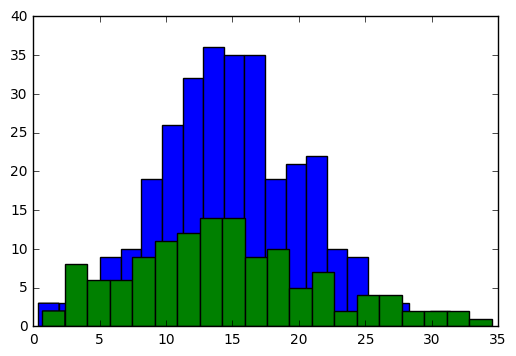

In [21]:
fig, ax = plt.subplots()
ax.hist(data_sal, bins=20)
ax.hist(data_par_yoh, bins=20)

Looking at the distributions, it seems that while they have the same mean, the variance of each distribution may be different. All of the tests covered so far focus exclusively on the difference in *means* between two distributions. However, sometimes the mean isn't the statistic of interest between two distributions. To visualize this let's plot the "cumulative distribution function" of the data. This is another useful way of comparing datasets to one another:

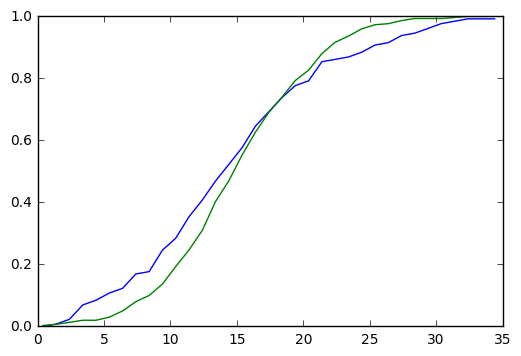

In [22]:
ecdf_py = ECDF(data_par_yoh)
ecdf_sa = ECDF(data_sal)

data_test = np.arange(np.min([data_par_yoh.min(), data_sal.min()]),
                      np.max([data_par_yoh.max(), data_sal.max()]))
fig, ax = plt.subplots()
for i_ecdf in [ecdf_py, ecdf_sa]:
    ax.plot(data_test, i_ecdf(data_test))


These two lines don't look quite the same. One of them seems to be rising more sharply than the other, reflecting the fact that the distribution is clustered around a single value rather than spread out across many values. In other words, the clustered distribution has smaller variance. How can we test for this?

One option is the Kolmogorov-Smirnov test. non-parametric test used to investigate the “shape” of a distribution. Let's see what it finds in this data

In [23]:
ks_2samp(data_par_yoh, data_sal)

Ks_2sampResult(statistic=0.13230769230769229, pvalue=0.076487831246934382)

Is it "significant"? No. But p-values are arbitrary constructions anyway. The important point is that this test makes a different kind of statement about the data than t-tests. Instead of asking "is the mean between the two distributions different?" it asks "is the shape of these distributions different?". This is a much more complicated question to ask, and there are many ways to test for this. Regardless, choosing the right test to fit your question requires careful consideration.

# An aside on p-values and multiple comparisons

We've performed a lot of tests in this notebook, and have often referred to p-values as some reflection of "significance". But is this the right thing to do?

Whenever we find a significant result, it's important to ask "what's the likelihood that this was a false positive?" Let’s try a little computer simulation, generating “fake” random data to help us understand how often false positive can occur.

1. One trial is defined as follows: take two random samples (n = 10) from a normal distribution and run a two-sample t-test on them, taking note of the p-value.
1. One experiment is 100 trials. (you should have 100 p-values at the end of an experiment). In the course of one experiment, how often are the two random samples significantly different from each other (at the level of alpha = 0.05)? Take a note of that number.
1. Run the above experiment about 100 more times… Isn’t it interesting that the number of statistically different “data sets” is always very close to 5? Why do you think this may be the case? What implications does it have for t-tests?

In [24]:
n_iterations = 100
n_trials = 100
n_per_trial = 10

pvalues = np.zeros([n_iterations, n_trials])
for ii in range(n_iterations):
    for jj in range(n_trials):
        data1 = np.random.randn(n_per_trial)
        data2 = np.random.randn(n_per_trial)
        results = ttest_ind(data1, data2)
        pvalues[ii, jj] = results.pvalue

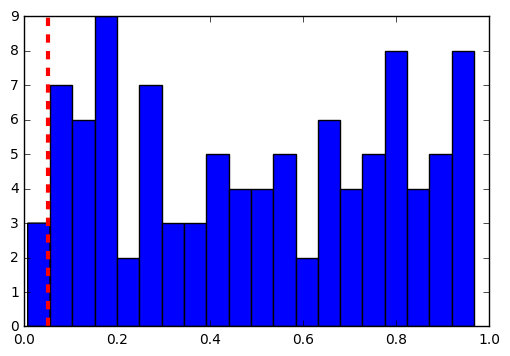

In [25]:
fig, ax = plt.subplots()
ax.hist(pvalues[0], bins=20)
ax.axvline(.05, c='r', ls='--', lw=3)

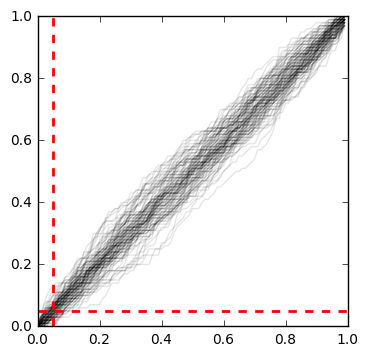

In [26]:
test_vals = np.arange(0, 1, .01)
fig, ax = plt.subplots(figsize=(4, 4))
for i_iteration in pvalues:
    i_ecdf = ECDF(i_iteration)
    ax.plot(test_vals, i_ecdf(test_vals), c='k', alpha=.1)
ax.axhline(.05, ls='--', c='r', lw=2)
ax.axvline(.05, ls='--', c='r', lw=2)

Notice how, in every iteration, roughly the same proportion of the distribution lies under .05. This is the expected false positive rate (assuming all our assumptions about normality hold).

This far we have focused on performing tests that use clever mathematical techniques. However, with the increasing computational power at our hands, there have evolved new ways for testing for differences between these groups. These computation-heavy methods inclue things like the statistical bootstrap and the permutation test.

# Estimating the difference using a confidence interval
Instead of using parametric statistics (or significance tests), another option is to simply give a confidence interval around the statistic of choice. For example, for the question "what is the expected mean of the difference between two distributions?", we might bootstrap the distribution of differences of the mean, and create confidence intervals around this value. See the [notebook on quantifying uncertainty](./simple_stats_and_uncertainty.ipynb) for a more thorough discussion.

In [29]:
n_boots = 1000
n_sal = data_sal.shape[0]
n_py = data_par_yoh.shape[0]
differences = np.zeros(n_boots)
for ii in range(n_boots):
    sample_sal = data_sal[np.random.randint(0, n_sal, n_sal)]
    sample_py = data_par_yoh[np.random.randint(0, n_py, n_py)]
    differences[ii] = np.mean(sample_sal) - np.mean(sample_py)
    
clo, chi = np.percentile(differences, [2.5, 97.5])

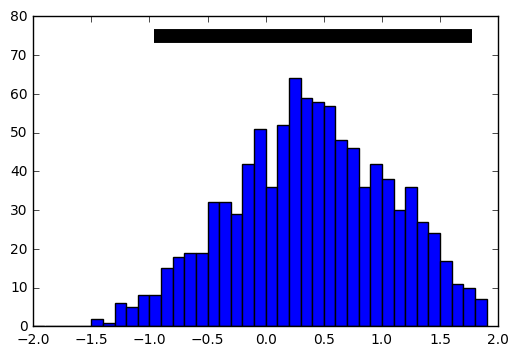

In [35]:
fig, ax = plt.subplots()
ax.hist(differences, bins=np.arange(-2, 2, .1))
ax.hlines(ax.get_ylim()[-1] + 5, clo, chi, lw=10, color='k')

In a sense, this confidence interval represents the uncertainty in the difference in means of these two distributions. In a technical sense, a N% confidence interval means: "repeating the data collection and re-calculating the confidence interval many times will cause the resulting confidence interval to overlap with the "true" mean N% of the time.

This seems a bit difficult to intuit, so let's simulate this below. We'll estimate a single value using our confidence interval: the mean of a distribution.

In [47]:
n = 2000
mn = 4
std = 2

n_simulations = 200
n_boots = 1000
all_differences = np.zeros([n_simulations, n_boots])
for ii in range(n_simulations):
    data = np.sqrt(2) * np.random.randn(n) + mn
    for jj in range(n_boots):
        sample = data[np.random.randint(0, n, n)]
        all_differences[ii, jj] = np.mean(sample)
        
# Now calculate the 95% CI for each simulation
clo, chi = np.percentile(all_differences, [2.5, 97.5], axis=1)

Above we've performed `n_simulations` bootstraps, so this gives us `n_simulations` confidence intervals. Let's see how many of them overlap with the "true" mean:

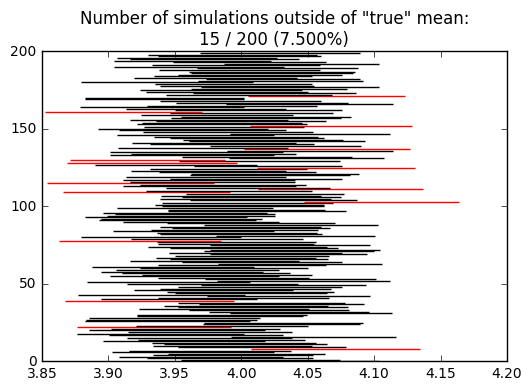

In [49]:
fig, ax = plt.subplots()
n_outside = 0
for ii, (iclo, ichi) in enumerate(zip(clo, chi)):
    if any([mn < iclo, mn > ichi]):
        color = 'r'
        n_outside += 1
    else:
        color = 'k'
    ax.hlines(ii, iclo, ichi, lw=1, color=color)
ax.set_title('Number of simulations outside of "true" mean:\n'
             '{} / {} ({:.3f}%)'.format(n_outside, n_simulations,
                                   100 * (float(n_outside) / n_simulations)))

Pretty close to 5%. If we were to run an infinite number of simulations, we'd quickly converge to 5% of cases where the confidence interval did *not* overlap with the true mean.

Another important thing to notice here is that the confidence interval itself does not tell you where *within the interval* the mean lies. It only says that the mean is likely somewhere within that interval. Many people intuitively want to say "the mean is most likely to be at the center of this interval" but this is not necessarily true.